In [50]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor

!pip install skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.preprocessing import RollingFeatures


[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Carrego meu dataset
url = 'daily-website-visitors.csv'
data = pd.read_csv(url)
data.head()


,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,"2,146","1,582","1,430",152
1,2,Monday,2,9/15/2014,"3,621","2,528","2,297",231
2,3,Tuesday,3,9/16/2014,"3,698","2,630","2,352",278
3,4,Wednesday,4,9/17/2014,"3,667","2,614","2,327",287
4,5,Thursday,5,9/18/2014,"3,316","2,366","2,130",236


In [ ]:
# Corrijo colunas que vieram como texto
cols_to_convert = ['Page.Loads', 'Unique.Visits', 'First.Time.Visits', 'Returning.Visits']

for col in cols_to_convert:
    data[col] = data[col].astype(str).str.replace(',', '')  # remove vírgula
    data[col] = pd.to_numeric(data[col])  # converte para número

In [ ]:
# Corrijo a coluna de Data
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data = data.set_index('Date')

# Define frequência diária (D)
data = data.asfreq('D', fill_value=0)

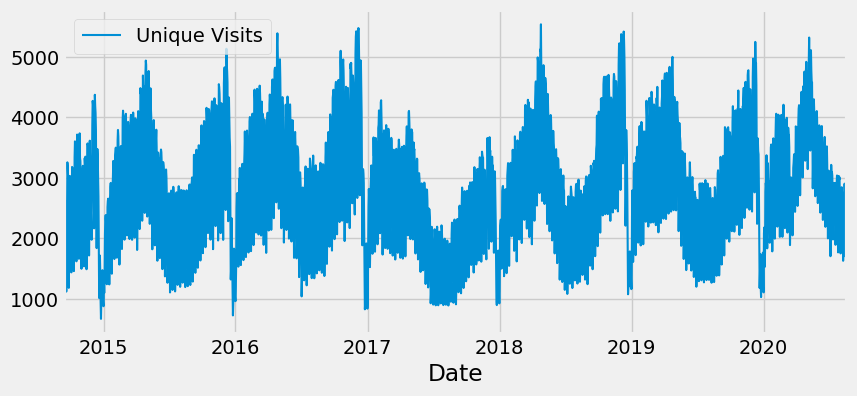

In [ ]:
# Visualizo a evolução dos acessos diários
fig, ax = plt.subplots(figsize=(9, 4))
data['Unique.Visits'].plot(ax=ax, label='Unique Visits')
ax.legend();

Treinamento: 2014-09-14 00:00:00 até 2020-05-11 00:00:00 (2067 registros)
Teste: 2020-05-12 00:00:00 até 2020-08-19 00:00:00 (100 registros)


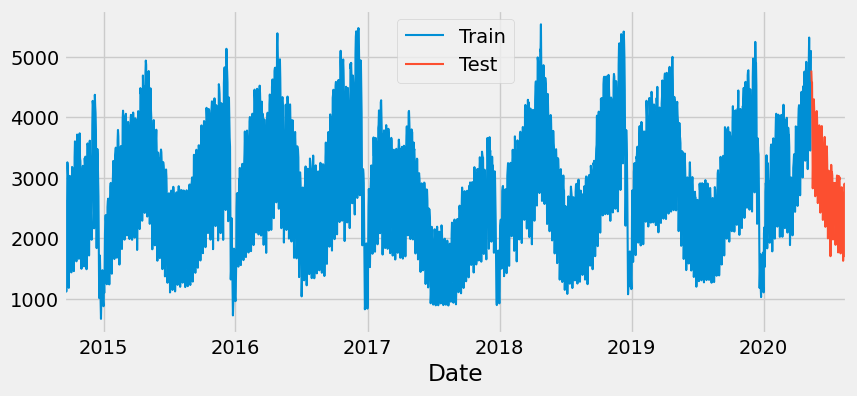

In [ ]:
# Defino quantidade de passos para teste
steps = 100

# Divido em treino e teste
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Treinamento: {data_train.index.min()} até {data_train.index.max()} ({len(data_train)} registros)")
print(f"Teste: {data_test.index.min()} até {data_test.index.max()} ({len(data_test)} registros)")

# Visualizar divisão
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Unique.Visits'].plot(ax=ax, label='Train')
data_test['Unique.Visits'].plot(ax=ax, label='Test')
ax.legend();

In [ ]:
# Crio modelo de previsão usando Random Forest
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(max_depth=10, n_estimators=100, random_state=123),
                lags      = 7,  # usa os últimos 7 dias para prever
                window_features = RollingFeatures(stats=['mean'], window_sizes=[7])
             )

# Treino o modelo
forecaster.fit(y=data_train['Unique.Visits'], exog=None)
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: RandomForestRegressor 
Lags: [1 2 3 4 5 6 7] 
Window features: ['roll_mean_7'] 
Window size: 7 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2014-09-14 00:00:00'), Timestamp('2020-05-11 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: D 
Regressor parameters: 
    {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth':
    10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None,
    'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100,
    'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0,
    'warm_start': False} 
fit_kwargs: {} 
Creation date: 2025-04-28 19:40:47 
Last fit date: 2025-04-28 19:40:50 
Skforecast version: 0.15.1 
Python version: 3.10.2 
Forecaster id: None

In [ ]:
# Faço predição
predictions = forecaster.predict(steps=steps, exog=None)
predictions.head()

2020-05-12    5058.525799
2020-05-13    4934.259130
2020-05-14    4628.392222
2020-05-15    4125.154794
2020-05-16    3635.792277
Freq: D, Name: pred, dtype: float64

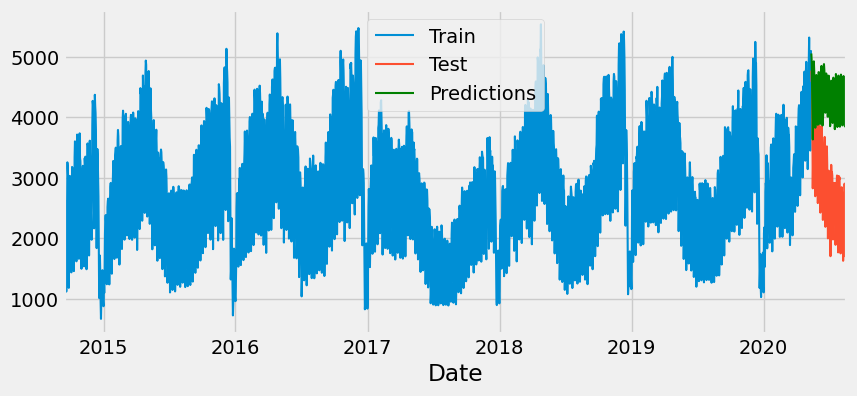

In [58]:
# Plotar resultados
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Unique.Visits'].plot(ax=ax, label='Train')
data_test['Unique.Visits'].plot(ax=ax, label='Test')
predictions.plot(ax=ax, label='Predictions', color='green')
ax.legend();